In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (assuming it's in CSV format)
df = pd.read_csv(r'C:\Users\ayush\Downloads\Tweets.csv\Tweets.csv')

# Inspect the data
print(data.head())

# Extract the features and labels
X = data[['text', 'tweet_id']]  # Assuming numerical features are included
y = data['airline_sentiment']  # Assuming the labels are in a column named 'sentiment'


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [108]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#nltk.download('stopwords')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenize
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]  # Lemmatize and remove stop words
    text = ' '.join(text)
    return text

X['text'] = X['text'].apply(preprocess_text)


C:\Users\ayush\AppData\Local\Temp\ipykernel_22356\635708292.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].apply(preprocess_text)


In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# Use CountVectorizer instead of TfidfVectorizer
count_vectorizer = CountVectorizer(max_features=5000)  # Adjust the max_features as needed
X_count = count_vectorizer.fit_transform(X['text'])

# Combine the CountVectorizer features with the numerical features
X_combined = hstack([X_count, X[['tweet_id']].values])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [112]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Define the base models
rf = RandomForestClassifier(random_state=42)

rf_clf=rf.fit(X_train, y_train)  # Fitting the model

# Now access the feature importances
feature_importances = rf.feature_importances_
nb = MultinomialNB()
nb_clf=nb.fit(X_train,y_train)

# Define the stacking classifier
estimators = [
    ('rf', rf),
    ('nb', nb)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())


In [113]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

# Define the function to optimize
def optimize_rf(n_estimators, max_depth, min_samples_split):
    rf.n_estimators = int(n_estimators)
    rf.max_depth = int(max_depth)
    rf.min_samples_split = int(min_samples_split)
    
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Define the hyperparameter space
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10)
}

optimizer = BayesianOptimization(
    f=optimize_rf,
    pbounds=pbounds,
    random_state=42
)


In [114]:
optimizer.maximize(init_points=5, n_iter=20)

# Extract the best parameters
best_params = optimizer.max['params']
rf.n_estimators = int(best_params['n_estimators'])
rf.max_depth = int(best_params['max_depth'])
rf.min_samples_split = int(best_params['min_samples_split'])


|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7886    | 5.622     | 9.606     | 159.8     |
| 2         | 0.7896    | 7.191     | 3.248     | 73.4      |
| 3         | 0.7865    | 3.407     | 8.929     | 140.2     |
| 4         | 0.7893    | 7.957     | 2.165     | 195.5     |
| 5         | 0.7886    | 8.827     | 3.699     | 77.27     |
| 6         | 0.7896    | 5.879     | 3.947     | 69.38     |
| 7         | 0.7879    | 4.398     | 9.821     | 187.9     |
| 8         | 0.7886    | 3.0       | 10.0      | 72.57     |
| 9         | 0.79      | 10.0      | 2.0       | 68.63     |
| 10        | 0.7903    | 8.643     | 2.12      | 58.06     |
| 11        | 0.7893    | 9.888     | 7.901     | 51.47     |
| 12        | 0.7883    | 3.0       | 2.0       | 54.68     |
| 13        | 0.7893    | 10.0      | 5.653     | 61.82     |
| 14        | 0.7889    | 6.246     | 2.0       | 62.44     |
| 15    

In [118]:
stacking_clf.fit(X_train, y_train)
y_pred =stacking_clf.predict(X_test)


In [120]:
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Stacking Classifier Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Final Stacking Classifier Accuracy: 0.7910
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1889
     neutral       0.65      0.42      0.51       580
    positive       0.77      0.67      0.72       459

    accuracy                           0.79      2928
   macro avg       0.75      0.68      0.70      2928
weighted avg       0.78      0.79      0.78      2928



IndexError: index 5000 is out of bounds for axis 0 with size 5000

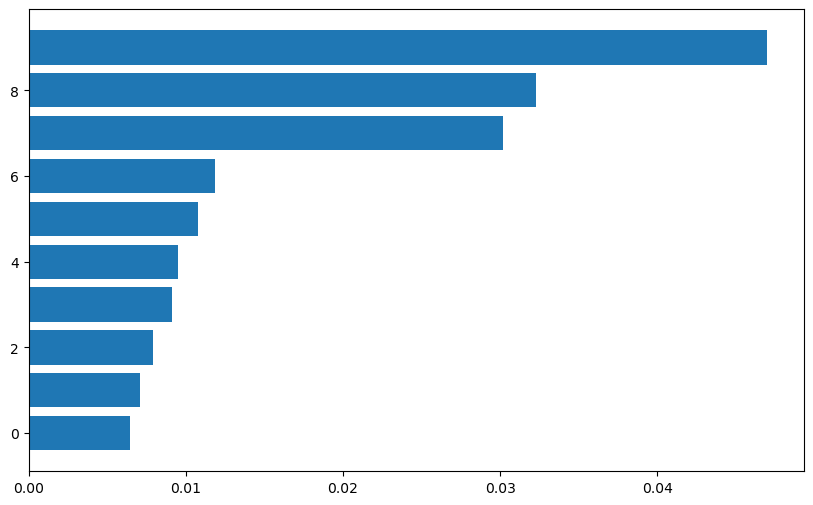

In [122]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = rf.feature_importances_ 
indices = np.argsort(feature_importances)[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [tfidf.get_feature_names_out()[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()
